# Reads in file of 3D particle positions, projects onto tomographic bin and computes convergence power spectrum

In [1]:
from scipy import ndimage
import numpy as np
import h5py
import pylab as plt
import math
import scipy.stats as stats

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
import time

In [2]:
# Analysis parameters:

N        = 128     # Image size N x N  (suggest 64 or 128)
Npix_los = 256    # Number of radial shells to compute (suggest 128 or 256)
L        = 4000   # Size of 3D grid in radial direction (Mpc).  Chosen equal to the box size

halfN    = int(N/2+0.5)

origin   = np.array([-L/2., -L/2., 0.])  # Place observer in middle of face of box.  Assumes 3D box is a cube.

# Cosmology:

omega_m  = 0.3
h        = 0.677
c        = 3e5

# Unsure if there should be a factor h^2 here (Note added in case power spectrum is off by h^4):

fact = 1.5 * 100**2 * omega_m / c**2

astropy_cosmo = FlatLambdaCDM(H0=h * 100 * u.km / u.s / u.Mpc, Om0=omega_m, Ob0=0.049)

comoving_grid = np.arange(1e-3, 4500, 0.1)
z_table = z_at_value(astropy_cosmo.comoving_distance, comoving_grid * u.Mpc / h, method='bounded').value

In [3]:
def redshift_from_comoving_distance(comoving_dist):
    redshift = np.interp(comoving_dist, comoving_grid, z_table)
    return redshift

def Jacobian(redshift):
  E = np.sqrt(omega_m * (1+redshift)**3 + (1-omega_m))
  return 100 * E / c

def weights(z, mean=1.0, std=0.14):
  exponent = - 0.5 * ((z - mean) / std)**2
  norm = std * (2. * np.pi)**0.5
  return np.exp(exponent) / norm

def Mpc2spherical(x,y,z):
  r = (x**2 + y**2 + z**2)**0.5
  x_angle = np.arcsin(x / r)
  y_angle = np.arcsin(y / r)  
  return r, x_angle, y_angle

def angular_coord_particles(part, origin):
  x = part[:,0] + origin[0]
  y = part[:,1] + origin[1]
  z = part[:,2] + origin[2]

  r, x_angle, y_angle = Mpc2spherical(x,y,z)
    
  print('Min and max values of x:',np.min(x),np.max(x))
  return r, x_angle, y_angle

In [5]:
# Load the particle data:

filename='/data80/nporqueres/sims_borg_forward/fiducial/output_random_0000.h5'

f = h5py.File(filename, "r")

print('hdf5 particle file loaded')

# Extract 3D coordinates of particles into (Npart,3) array:

particle_positions = f['u_pos'][:]

# Translate x,y,z, to r and angles:

r, x_angle, y_angle = angular_coord_particles(particle_positions, origin)

Npart = len(particle_positions)
print('Number of particles:',Npart)
n_average = Npart / L**3  

hdf5 particle file loaded
Min and max values of x: -1999.9999442602448 1999.999998837277
Number of particles: 134217728


In [6]:
# Assign particles to voxels in 3D (anglex,angley,radius):

time0 = time.time()

anglemax  = np.arctan(0.5)
dangle    = anglemax/halfN
    
# coord contains various particle coordinates:
coord      = np.empty((Npart,6))
    
coord[:,0] = r
coord[:,1] = x_angle
coord[:,2] = y_angle
coord[:,3] = redshift_from_comoving_distance(r)
coord[:,4] = x_angle/dangle + halfN  # x position (index)
coord[:,5] = y_angle/dangle + halfN  # y position (index)
    
print('Coordinates assigned')

print('Time:',time.time()-time0)

new_pixel_count = np.zeros((N+1,N+1,Npix_los*3),dtype=int)
xpos            = np.empty(Npart,dtype=int)
ypos            = np.empty(Npart,dtype=int) 
kappa           = np.zeros((N,N,Npix_los))
radial_bin      = np.zeros(Npart,dtype=int)

# Radii of thin radial shells (on which to compute kappa, which is then [weighted] summed to do tomography):
r_pix_los = np.arange(0, Npix_los, 1) * L / Npix_los
dr        = L/Npix_los
redshift  = redshift_from_comoving_distance(r_pix_los)

time2 = time.time()

xpos[:]       = np.round(coord[:,4]).astype(int)
ypos[:]       = np.round(coord[:,5]).astype(int)

# Put particles that are out of the field (either on the sky, or too far away) on to the edges/furthest slice 
# (i.e. elements labelled by any of [N,N,Npix_los] are excluded particles, ignored later):

radial_bin[:] = np.where(coord[:,0]<L,np.round(coord[:,0]/dr).astype(int),Npix_los)

xpos[:] = np.where(xpos[:] > -1, xpos[:], N)
xpos[:] = np.where(xpos[:] <  N, xpos[:], N)

ypos[:] = np.where(ypos[:] > -1, ypos[:], N)
ypos[:] = np.where(ypos[:] <  N, ypos[:], N)

# Compute the convergence on spherical shells (they *are* spherical - the last index is a radius)

# Improve this later: the volume of each narrow pyramid changes slightly across the box

approx_solid_angle = (np.arctan(0.5)/halfN)**2

# Note the weight include dr and the Jacobian from z to r:

w = weights(redshift) * Jacobian(redshift) * dr

# Declare arrays to do the Sunglass summation:

dSum1 = np.zeros((N+1,N+1,Npix_los+1))
dSum2 = np.zeros((N+1,N+1,Npix_los+1))
Sum1  = np.zeros((N+1,N+1,Npix_los))
Sum2  = np.zeros((N+1,N+1,Npix_los))

# Overall amplitude to change sums to kappa:

factor = fact/n_average/approx_solid_angle

Coordinates assigned
Time: 11.89497995376587


In [7]:
# This might not be very efficient because of for loops.  The sum over particles (part) is the slowest step. 

# dSum1 and dSum2 collect the contributions to the sunglass sums from particles in the narrow r ranges.
# Sum1 and Sum2 then add them (rather inefficiently, but this a small calculation)

for part in range(Npart): 

    oneplusz = 1.+coord[part,3]
    ix = xpos[part]
    iy = ypos[part]
    jbin = radial_bin[part]
       
    dSum1[ix,iy,jbin]  += oneplusz/coord[part,0]
    dSum2[ix,iy,jbin]  += oneplusz
    
# This line can be removed for speed but can be a useful diagnostic - the number of particles per pixel shouln't
# vary systematically with position in the grid.
#    new_pixel_count[ix,iy,jbin] += 1

# kappa contains the convergence field on spherical shells, finely-spaced (shell j indexed last)

for j in range(1, Npix_los):
    Sum1[:,:,j]=np.sum(dSum1[:,:,0:j],axis=2)
    Sum2[:,:,j]=np.sum(dSum2[:,:,0:j],axis=2)
            
    kappa[:,:,j] =  factor*(Sum1[:N,:N,j]-Sum2[:N,:N,j]/r_pix_los[j])

# Subtract the mean:

    kappa[:,:,j] += -np.average(kappa[:,:,j])
                                
time3 = time.time()
                  
print('Time (new method) =',time3-time2)

Time (new method) = 216.93903255462646


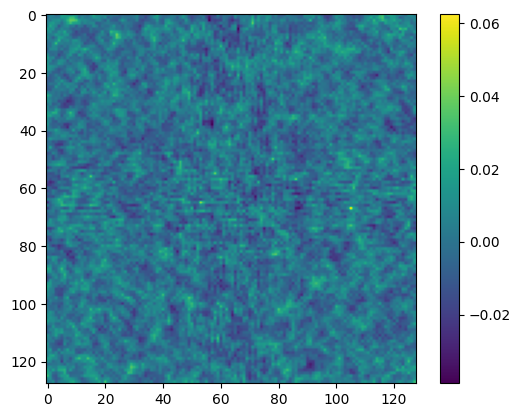

0.009866660976615402


In [8]:
# Plot a distant slice:

jplot = Npix_los-1
plt.imshow(kappa[:,:,jplot]-np.average(kappa[:,:,jplot]))
plt.savefig('KappaNewFar'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'_lightcone_fast.pdf')
plt.colorbar()
plt.show()
print(np.std(kappa[:,:,jplot]-np.average(kappa[:,:,jplot])))

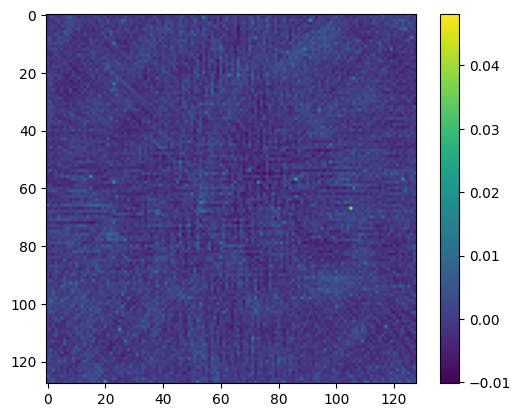

0.003229183054748275


In [9]:
# Plot a nearer slice:

jplot = int(Npix_los*0.3)
plt.imshow(kappa[:,:,jplot]-np.average(kappa[:,:,jplot]))
plt.savefig('KappaNewNear'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'_lightcone_fast.pdf')
plt.colorbar()
plt.show()
print(np.std(kappa[:,:,jplot]-np.average(kappa[:,:,jplot])))

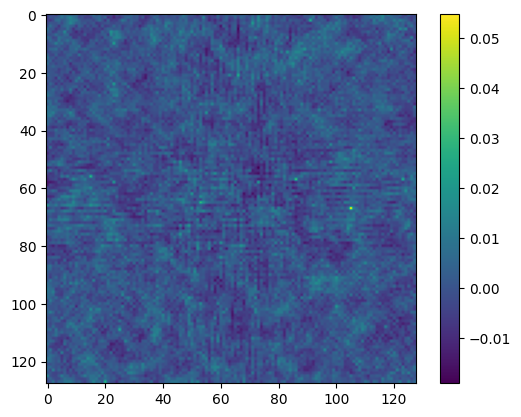

In [10]:
# Calculate kappa for a tomographic bin (kappa_tomo) by integrating over the radial window.
# w includes the n(z) weight, the Jacobian, and the element dr.

kappa_tomo = np.zeros((N,N))
for i in range(0,N):
  for j in range(0,N):
    kappa_tomo[i,j] = np.sum(kappa[i,j,:] * w)

# Compute the average empirically, and subtract

kappa_tomo=kappa_tomo - np.average(kappa_tomo)

plt.imshow(kappa_tomo)
plt.colorbar()
plt.savefig('KappaNew_tomo_fast_'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'_lightcone_fast.pdf')
plt.show()

np.save('kappa_tomo_sunglass_fast_'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'_lightcone_fast', kappa_tomo)

Fundamental       = 6.775819809273148
Density of states = 0.02178092419878928
Number of pixels on a side: 128 128
Variance of image    = 2.8117359822840457e-05
Parseval variance    = 2.8117359822840457e-05
D_ell variance       = 2.476308884989413e-05


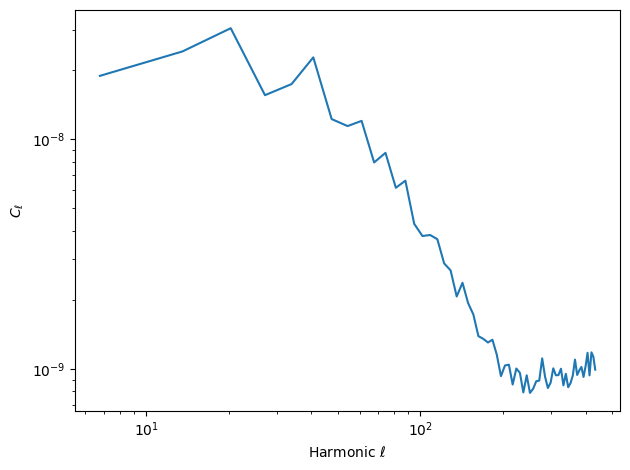

In [11]:
# Calculate power spectrum of the tomographic field.
# This is inherited from a separate code - not modified.  

# Size of field and various derived quantities:

field_size_rad    = 2.0 * np.arctan(0.5)

l_fundamental     = 2.* np.pi / field_size_rad
density_of_states = 1.0/l_fundamental**2

print('Fundamental       =', l_fundamental)
print('Density of states =', density_of_states)

# Fourier Transform

# Round up the size along this axis to an even number
n    = int( math.ceil(kappa_tomo.shape[0] / 2.) * 2 )
npix = n*n

print('Number of pixels on a side:',kappa_tomo.shape[0],n)

ft      = np.fft.fftn(kappa_tomo)
power2d = np.abs(ft)**2 / npix**2   

image_variance = ndimage.variance(kappa_tomo)

print('Variance of image    =', image_variance)

# Find frequencies

kvec = np.fft.fftfreq(n,d=1.0) * n

kvec2D = np.meshgrid(kvec, kvec)

ell = np.sqrt(kvec2D[0]**2 + kvec2D[1]**2) * l_fundamental
ell = ell.flatten()

power=power2d.flatten()

print('Parseval variance    =',np.sum(power))

# Construct bins in ell space (separated by the fundamental wavenumber):

ell_bins = np.arange(0.5, n//2+1, 1.) * l_fundamental
ell_vals = 0.5 * (ell_bins[1:] + ell_bins[:-1])

binned_power, bin_edges, bin_number = stats.binned_statistic(ell, power, statistic = "mean", bins = ell_bins)

D_ell = binned_power * (2.* ell_vals+1) * field_size_rad**2 /(4.*np.pi)

bin_width = bin_edges[1]-bin_edges[0]

D_ell_variance = np.sum(D_ell*bin_width)

print('D_ell variance       =',D_ell_variance)

# Plot power spectrum:

X_ell = D_ell * ell_vals *(ell_vals + 1) / (2.*ell_vals) * 2.
C_ell = binned_power * field_size_rad**2

plt.loglog(ell_vals, C_ell)
plt.xlabel("Harmonic $\ell$")
plt.ylabel("$C_\ell$")
           
plt.tight_layout()

plt.savefig('power_spectrum'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'_lightcone_fast.png', dpi = 300, bbox_inches = "tight")
plt.show()

In [12]:
np.savez('Cl'+str(L)+'_'+str(N)+'_'+str(Npix_los)+'fast.png',x=ell_vals,y=C_ell)